# Notebook with VAE model and no conditionning

## Loading Libraries 

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

import warnings
warnings.filterwarnings('ignore')

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [4]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

In [5]:
#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

In [6]:
#Visualize data frame head
x_conso.head(5)

ds  consumption_France  temperature_France  is_holiday_day
0 2012-12-28 00:00:00             59679.0            8.817600             0.0
1 2012-12-28 00:30:00             58103.0            8.690875             0.0
2 2012-12-28 01:00:00             55354.0            8.564150             0.0
3 2012-12-28 01:30:00             55196.0            8.440525             0.0
4 2012-12-28 02:00:00             54324.0            8.316900             0.0

# Make training set of daily electrical consumption profiles and conditions 
In this experiment there is no condition to pass. This is not something we can do with a PCA anyway

In [7]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [8]:
dict_xconso = {'train': x_conso}

In [9]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [85]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
type_x = ['conso']
type_cond = ['weekday','day']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond)

month (1830, 12)
weekday (1830, 1)
(1830, 13)
weekday (1830, 1)
day (1830, 7)
(1830, 8)


In [114]:
#A VAE is a CVAE with a null feature as a condition  

#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
x = dataset['train']['x'][0]
cond_pre =np.zeros((nPoints,), dtype=int)#

dataset['train']['x'] = [x,cond_pre]
dataset['train']['y1'] = dataset['train']['y'] #the CVAE model has two outputs which are identifcal to compute the two losses


#get conditions in array
day_emb =dataset_cond['train']['x'][1][:,0:7]
wkday_emb=dataset_cond['train']['x'][1][:,7:]
to_emb=dataset_cond['train']['x'][1]

x_cond = dataset_cond['train']['x'][0]

dataset_cond['train']['x'] = [x,day_emb,wkday_emb]

In [13]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
calendar_info=calendar_info.assign(snow=0, floods=0, storm=0, hurricane=0, rain=0, cold=0, hot=0)

from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    calendar_info.iloc[row,5:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            calendar_info.iloc[row,5:]+=np.asarray(meteo_events.iloc[k,2:-1])

calendar_info.iloc[:,5:] = 1*(calendar_info.iloc[:,5:]>0)

In [441]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [459]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
calendar_info['potential_bridge_holiday'].describe()

count    1830.000000
mean        0.008743
std         0.093121
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: potential_bridge_holiday, dtype: float64

In [445]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean,variationMax,variationMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor',
    'load_delta_max' : 'regressor',
    'load_delta_mean' : 'regressor'
}

# Construction of the projector

In [423]:
from keras.callbacks import TensorBoard
from time import time

def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [422]:
x_conso.shape

(87830, 4)

# Build and train models

## PCA

In [16]:
from sklearn.decomposition import PCA
z_dim = 4

pca = PCA(n_components=z_dim)

mae loss:  0.03908255581874562
mse loss:  0.003218743535482829
mae loss:  0.034721153318065766
mse loss:  0.0024231754553329515
mae loss:  0.036403466138767264
mse loss:  0.00269835332036256
mae loss:  0.03560118439333923
mse loss:  0.002508804527183488
mae loss:  0.033997752813009485
mse loss:  0.0022774024352398086
Mutual Information Gap : 0.22


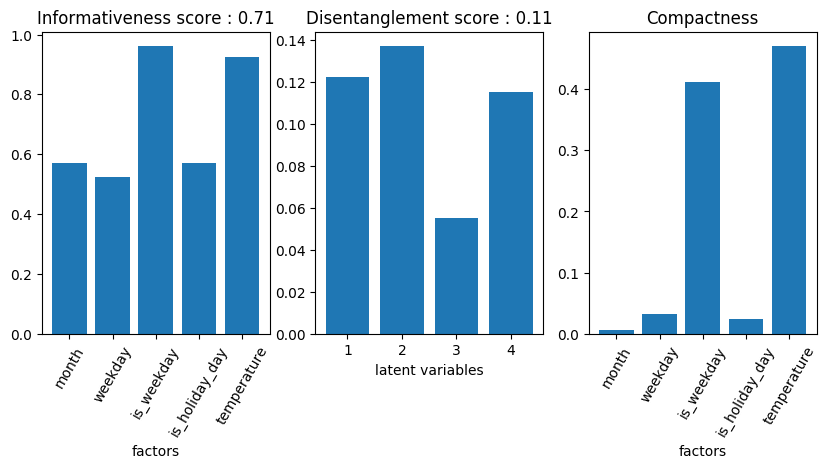

In [57]:
#Test for the PCA
from sklearn.model_selection import KFold # import KFold
import sklearn as sk
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(x) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(x):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = x[train_index], x[test_index]
    principalComponents = pca.fit_transform(X_train)
    X_test_pca=pca.transform(X_test)
    x_hat = pca.inverse_transform(X_test_pca)
    print("mae loss: ", sk.metrics.mean_absolute_error(X_test,x_hat))
    print("mse loss: ", sk.metrics.mean_squared_error(X_test,x_hat))
   # y_train, y_test = y[train_index], y[test_index]

x_encoded = pca.transform(x)
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');



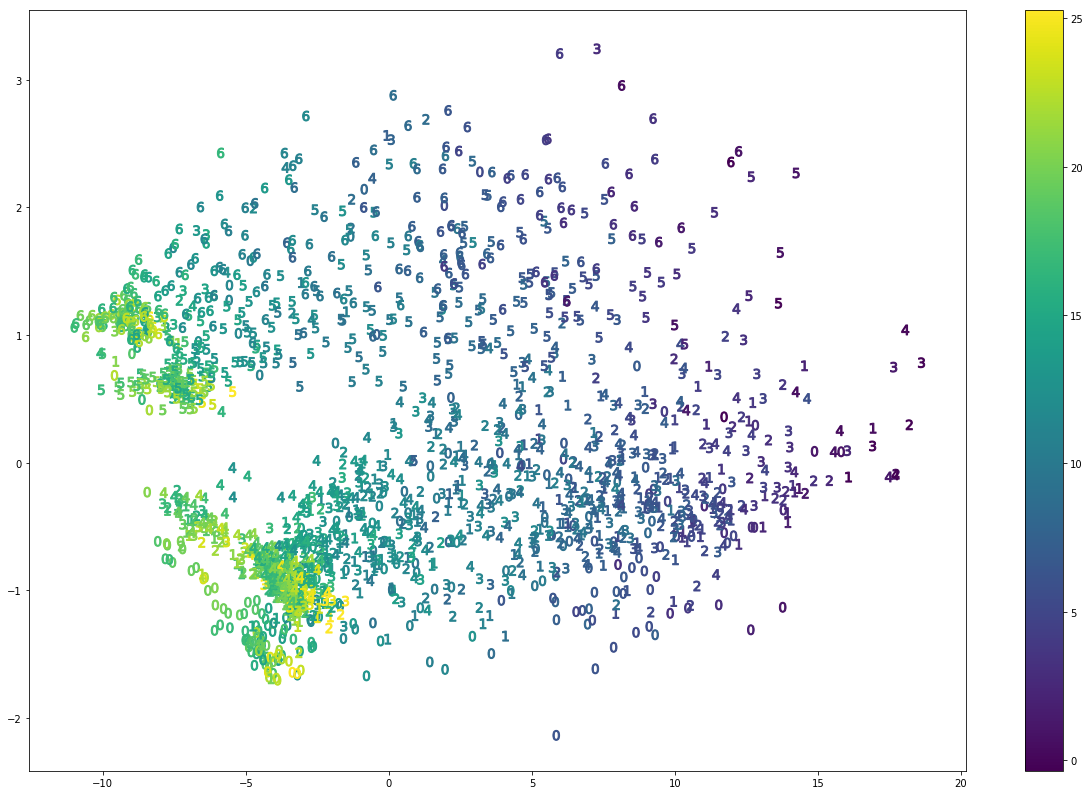

In [58]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(21,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100) 
plt.colorbar();

## Generative models

In [37]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.callbacks)
from FeaturesScore.scoring import *

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
z_dim = 4
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
lr=3e-4
input_dim = dataset['train']['x'][0].shape[1]


In [21]:
to_emb_dim=[12,48]
emb_dims=[[6,3],[12,4]]
emb_to_z_dim=[z_dim,z_dim]
cond_pre_dim=dataset_cond['train']['x'][1].shape[1]

## Autoencoder

In [22]:
epochs = 800
batch_size = 16

In [285]:
#Autoencoder
name_model = 'cae_conso-M_T_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
model_CAE = CVAE.cvae_model.CAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                name=name_model, output=path_out)

L2 loss
True
L2 loss
True
L2 loss
True
L2 loss
True
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 4)            5390        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 (None, 4

In [286]:

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



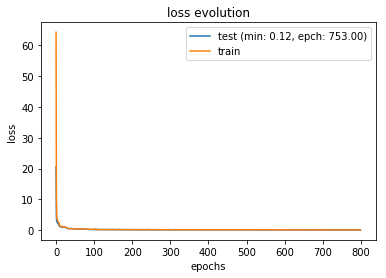

In [287]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=False #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


In [63]:
       
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded = model_CAE.encoder.predict(input_encoder)
x_encoded

array([0.467126  , 0.3420583 , 0.44832203, 0.28626257], dtype=float32)

In [61]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

IndexError: tuple index out of range

## VAE

In [91]:
#Autoencoder
name_model = 'cvae_conso-M_T_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE = CVAE.cvae_model_mixture.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                name=name_model, output=path_out)

L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)         

In [92]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

[2184.8354   253.34421 1294.0288   180.32521]
4.492104036458333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.889094  0.384656  0.412926        0.112727     0.835827
random model    0.483654  0.142566  0.096692        0.032727    -0.423483
0 Epochs ...  - loss: 37.2940 - decoder_loss: 36.3215 - decoder_for_kl_loss: 0.9725 - decoder_kl_loss: 0.9725 - decoder_recon_loss: 36.3215 - decoder_for_kl_kl_loss: 0.9725 - decoder_for_kl_recon_loss: 36.3215 - val_loss: 28.3459 - val_decoder_loss: 25.6036 - val_decoder_for_kl_loss: 2.7423 - val_decoder_kl_loss: 2.7423 - val_decoder_recon_loss: 25.6036 - val_decoder_for_kl_kl_loss: 2.7423 - val_decoder_for_kl_recon_loss: 25.6036 val_loss 28.34591887427158 ... lambda Loss 1.0
[1609.4047     79.625694   76.07074  1321.6328  ]
4.069329046875
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.959450  0.482061  0.381680        0.174545     0.8

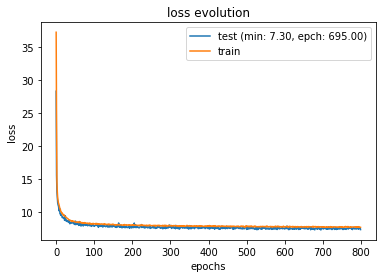

In [93]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


lambda_decreaseRate=-0.001 #parameter by default
lambda_min = 0.001
lambda_val=0.4
if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model_CVAE.main_train(dataset, training_epochs=int(3*epochs/4), batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model_CVAE.main_train(dataset, training_epochs=int(3*epochs/4), batch_size=batch_size, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


In [94]:
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded = model_CVAE.encoder.predict(input_encoder)[0]

Mutual Information Gap : 0.13


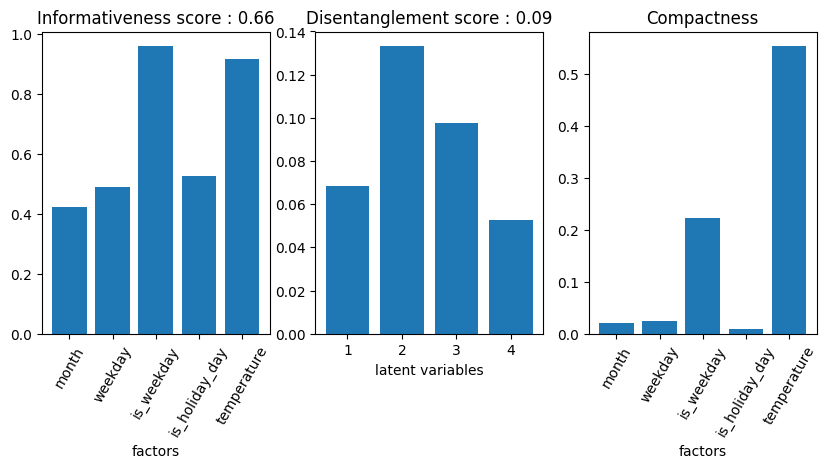

In [95]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

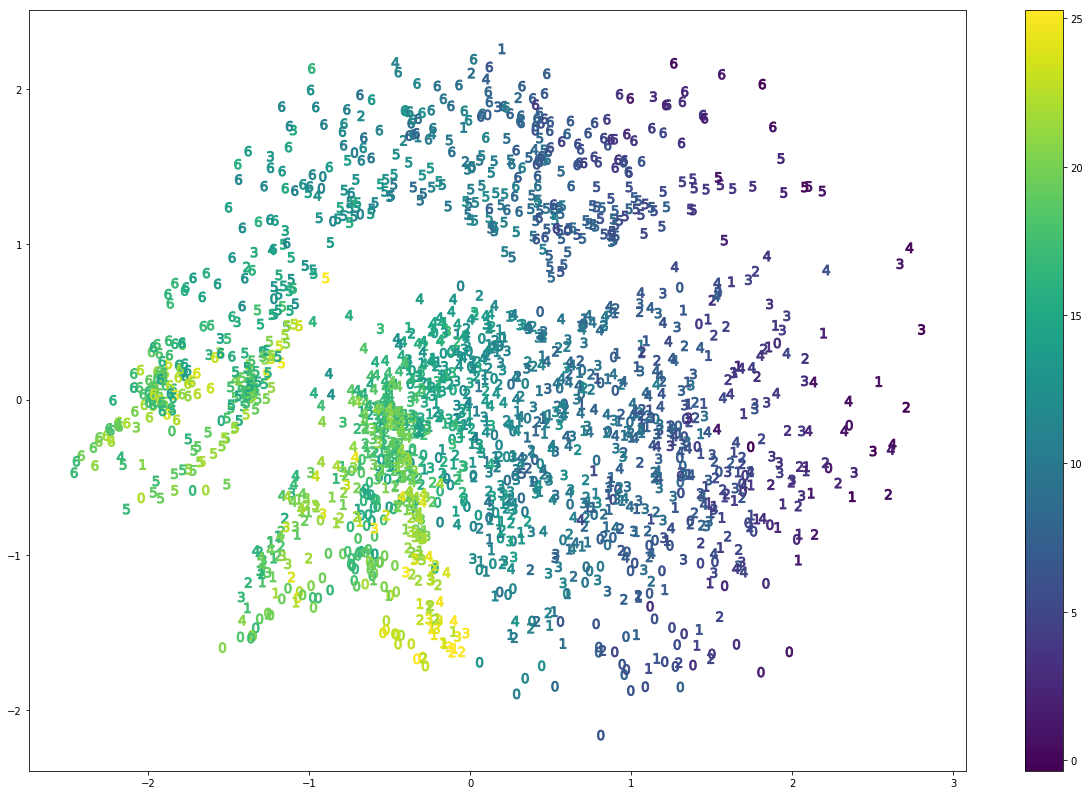

In [96]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(21,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100) 
plt.colorbar();

## VAE laplacian

In [102]:
name_model = 'cvae_laplacian_conso-M_T_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_laplacian = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                prior = 'Laplace',          
                                name=name_model, output=path_out)

L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)         

In [103]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

[170.85558 161.70311 462.4145  354.24374]
4.730379104166669
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.923592  0.450478  0.433367        0.218182     0.828680
random model    0.505741  0.149955  0.079254        0.040000    -0.439092
0 Epochs ...  - loss: 42.5266 - decoder_loss: 42.3884 - decoder_for_kl_loss: 0.1383 - decoder_kl_loss: 0.1383 - decoder_recon_loss: 42.3884 - decoder_for_kl_kl_loss: 0.1383 - decoder_for_kl_recon_loss: 42.3884 - val_loss: 39.2556 - val_decoder_loss: 39.1216 - val_decoder_for_kl_loss: 0.1341 - val_decoder_kl_loss: 0.1341 - val_decoder_recon_loss: 39.1216 - val_decoder_for_kl_kl_loss: 0.1341 - val_decoder_for_kl_recon_loss: 39.1216 val_loss 39.255628804691504 ... lambda Loss 1.0
[ 106.87635    78.072136 1948.1681   1497.2047  ]
3.8653971927083326
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.956644  0.495755  0.407258        0.181818     0.

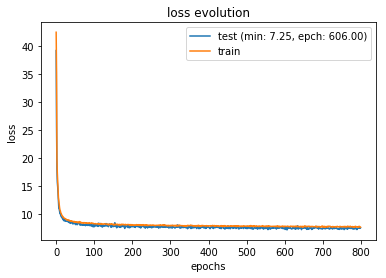

In [104]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE_laplacian.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE_laplacian.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


In [105]:
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded = model_CVAE_laplacian.encoder.predict(input_encoder)[0]

Mutual Information Gap : 0.10


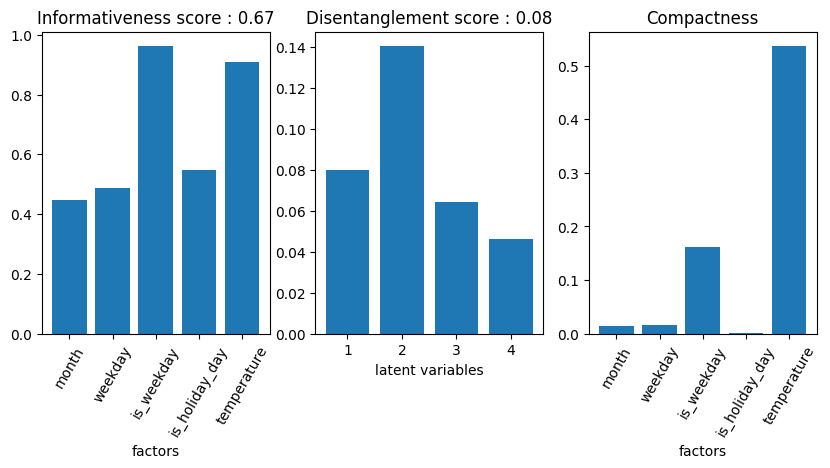

In [106]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

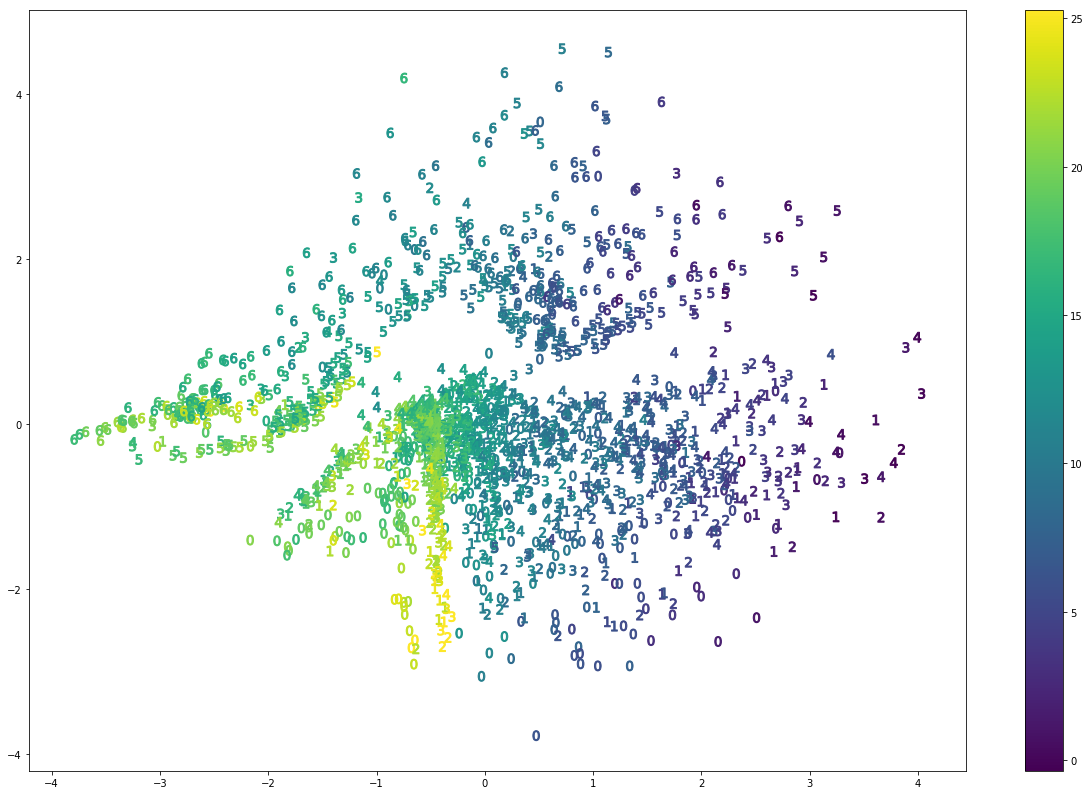

In [107]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(21,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100) 
plt.colorbar();

## InfoVAE

In [432]:
name_model = 'cvae_info_conso_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 0.4
gamma_val = 5
Beta = K.variable(beta_val, dtype='float32')
Gamma = K.variable(gamma_val, dtype='float32')
model_InfoVAE = CVAE.cvae_model.InfoVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=False,
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][0]

In [433]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

[2085.8645 2028.877   839.9999 1140.978 ]
5.306865427083336
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.746262  0.296230  0.372275        0.083636     0.776837
random model    0.492126  0.153001  0.069572        0.025455    -0.429916
0 Epochs ...  - loss: 39.0295 - decoder_loss: 38.6754 - decoder_for_kl_loss: 0.8852 - val_loss: 29.7304 - val_decoder_loss: 28.0319 - val_decoder_for_kl_loss: 4.2463 val_loss 29.73042357814768 ... lambda Loss 0.4000000059604645
[ 357.88748 1701.4902  1092.3225  1375.717  ]
3.387065234375001
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.964840  0.525863  0.467346        0.225455     0.908415
random model    0.482774  0.134460  0.083615        0.032727    -0.421788
100 Epochs ...  - loss: 5.2585 - decoder_loss: 2.9039 - decoder_for_kl_loss: 5.8866 - val_loss: 5.1093 - val_decoder_loss: 2.8291 - val_decoder_for_kl_loss: 5.7007 val_loss 5.109

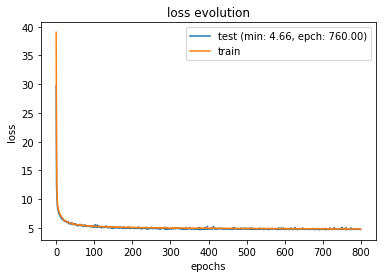

In [434]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_InfoVAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_InfoVAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


In [435]:
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded = model_InfoVAE.encoder.predict(input_encoder)[0]

Mutual Information Gap : 0.12


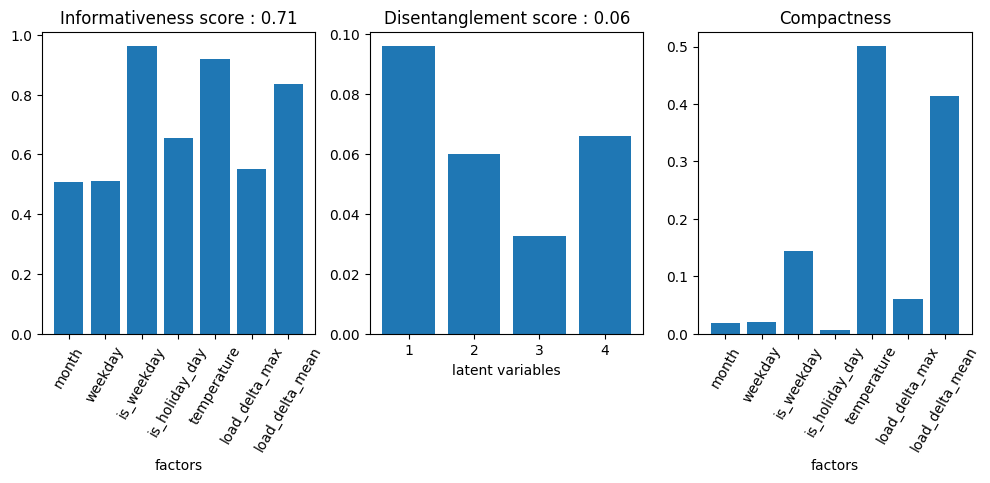

In [448]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100, figsize=(12,4), constrained_layout=True)

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');



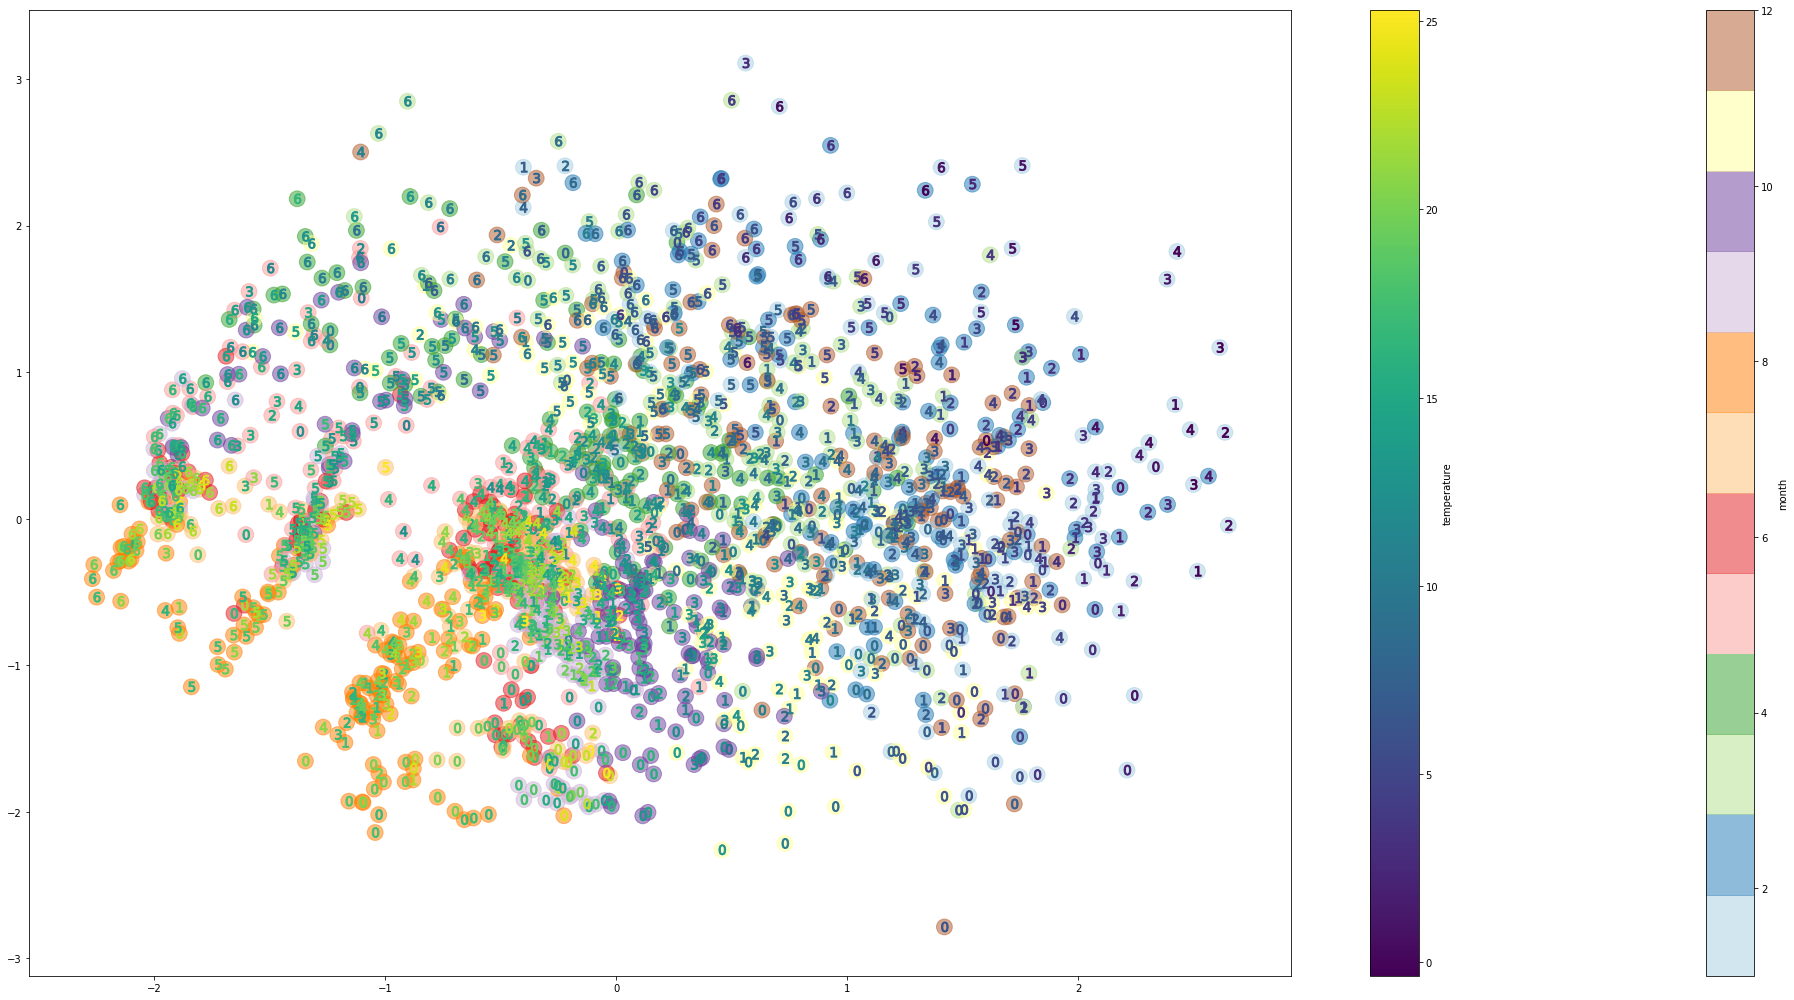

In [437]:
proj2D = PCA(2)
proj = proj2D.fit_transform(rot.transform(x_encoded))
plt.figure(figsize=(28,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=250, alpha=0.5, cmap = 'Paired')

plt.colorbar().set_label('month');
plt.tight_layout()
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100)

plt.colorbar().set_label('temperature')
plt.tight_layout()

In [449]:
x_hat = model_InfoVAE.cvae.predict(input_encoder)[0]
tensorboardProjection(name_model,dataset['train']['x'][0],x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True)

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/ModelComparison/VAE/projector/cvae_info_conso_30min-journalier


<Figure size 432x288 with 0 Axes>

In [430]:
dataset['train']['x'][0].shape

(1830, 48)

## VAE Modal : 7 modes

In [267]:
name_model = 'cvae_modal_conso_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_mode7 = CVAE.cvae_model_mixture.CVAE_modal(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                proba_mixture=np.ones(7)/7,         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 43619       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][3]

In [268]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



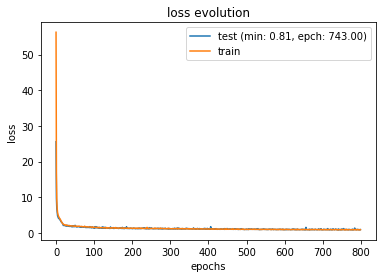

In [269]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=False #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE_mode7.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE_mode7.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


In [270]:
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded,_,_,z_y = model_CVAE_mode7.encoder.predict(input_encoder)

Mutual Information Gap : 0.33


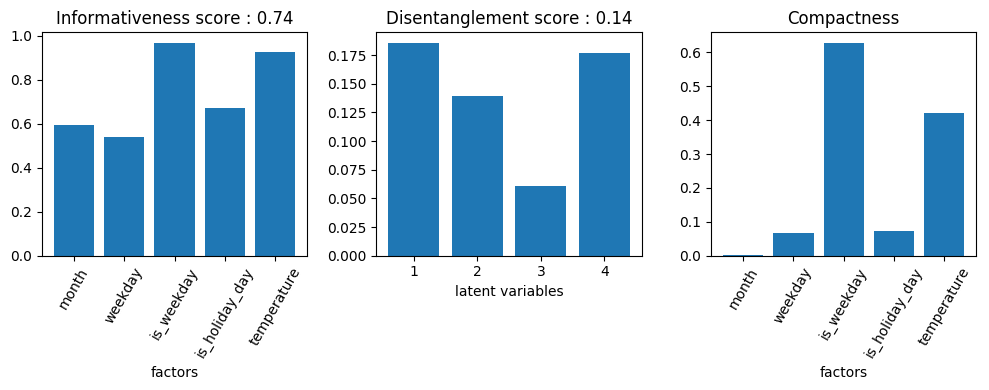

In [284]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize = True)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness')

plt.tight_layout();

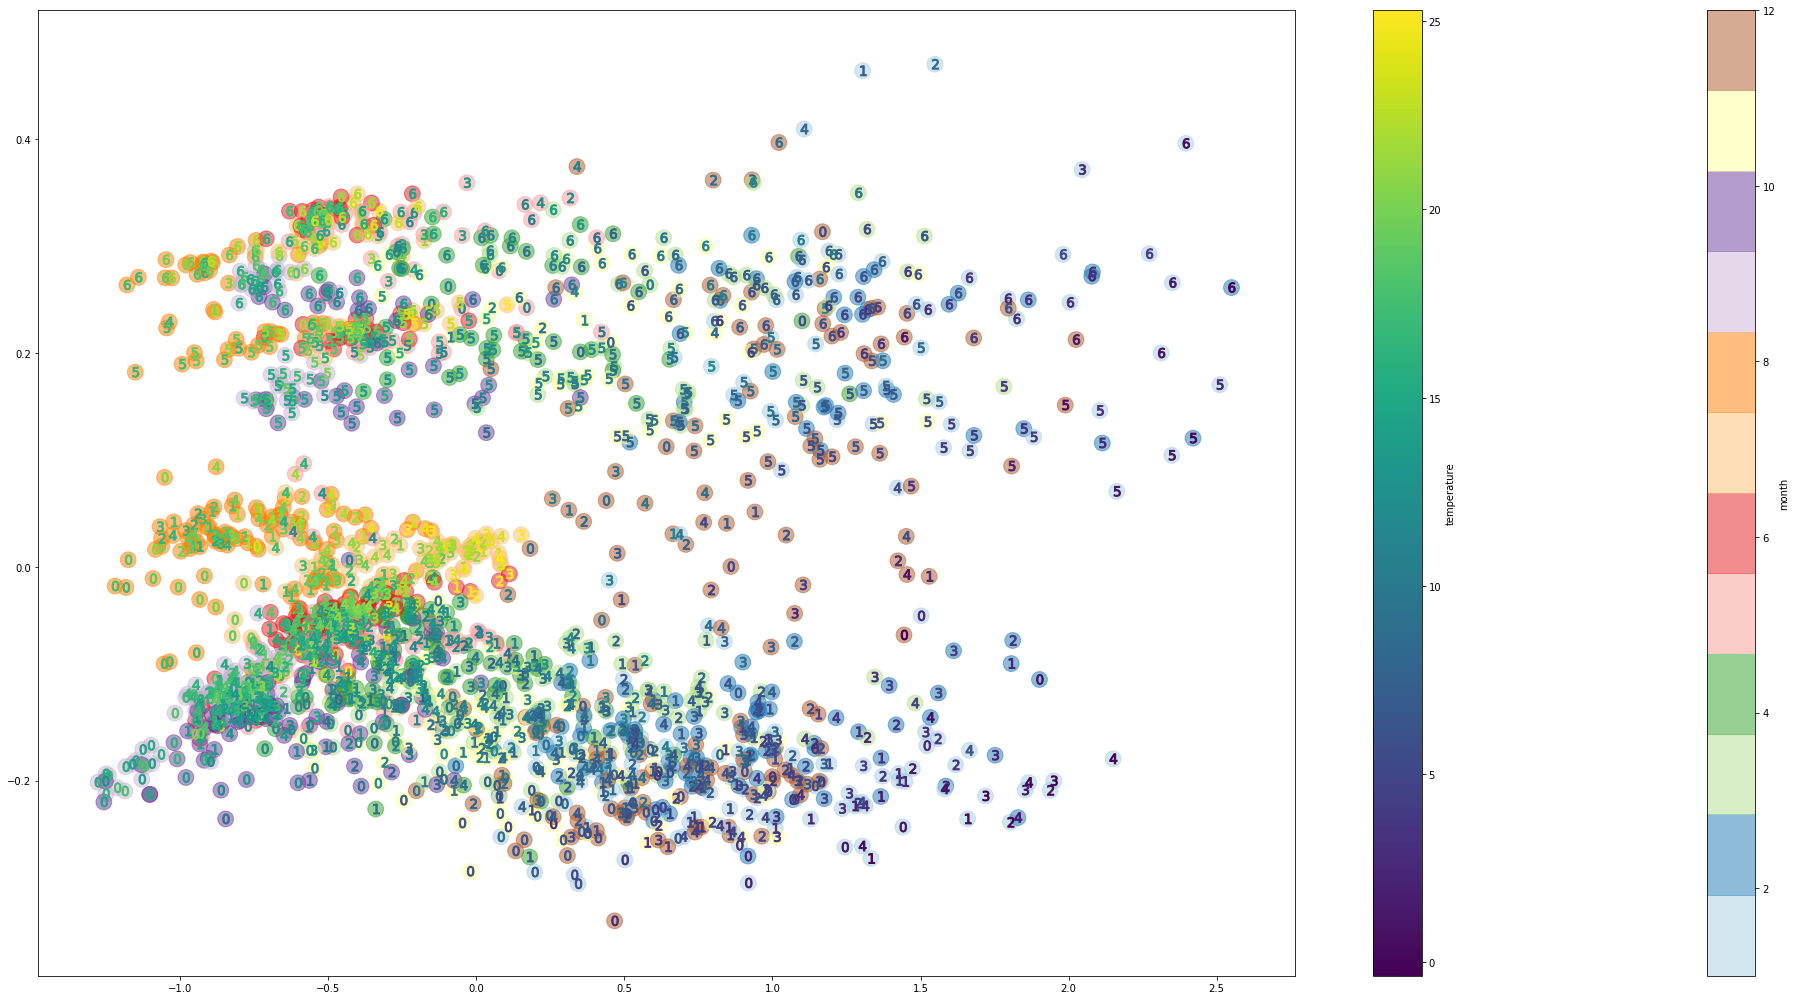

In [283]:
proj2D = PCA(2)
proj = proj2D.fit_transform(rot.transform(x_encoded))
plt.figure(figsize=(28,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=250, alpha=0.5, cmap = 'Paired')

plt.colorbar().set_label('month');
plt.tight_layout()
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100)

plt.colorbar().set_label('temperature')
plt.tight_layout()

In [80]:
x_hat = model_CVAE_mode7.cvae.predict(input_encoder)[0]
tensorboardProjection(name_model, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True)

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/ModelComparison/VAE/projector/cvae_mixture_conso_30min-journalier


<Figure size 432x288 with 0 Axes>

## CVAE cluster

In [495]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.callbacks)
from FeaturesScore.scoring import *

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [496]:
name_model = 'cvae_cluster_conso_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cluster7 = CVAE.cvae_model_mixture.CVAE_cluster(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                proba_mixture=np.ones(7)/7,         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 12064       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 [(None, 48), (None,  12122       encoder[1][2]

In [497]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [ ]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE_cluster7.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE_cluster7.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)




--- START TRAINING ---

[511.9672  179.79001 698.42426 238.51697]
4.315806502604164
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.939934  0.463472  0.527529        0.243636     0.847414
random model    0.473393  0.141541  0.084750        0.025455    -0.471390
0 Epochs ...  - loss: 41.1688 - decoder_loss: 39.4860 - decoder_for_kl_loss: 1.7530 - val_loss: 38.8122 - val_decoder_loss: 37.3986 - val_decoder_for_kl_loss: 1.5065 val_loss 38.81222509165279 ... lambda Loss 1.0
[ 431.8492  1536.8711   726.19885 1096.122  ]
4.646236874999999
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.933288  0.411272  0.336297        0.207273     0.834286
random model    0.488924  0.145925  0.078128        0.025455    -0.408577
100 Epochs ...  - loss: -14.2490 - decoder_loss: 3.7988 - decoder_for_kl_loss: -17.8740 - val_loss: -14.8416 - val_decoder_loss: 3.5742 - val_decoder_for_kl_loss: -18.2335 val_loss -14.84158131

In [485]:
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

x_encoded,_,z_y = model_CVAE_cluster7.encoder.predict(input_encoder)

Mutual Information Gap : 0.05


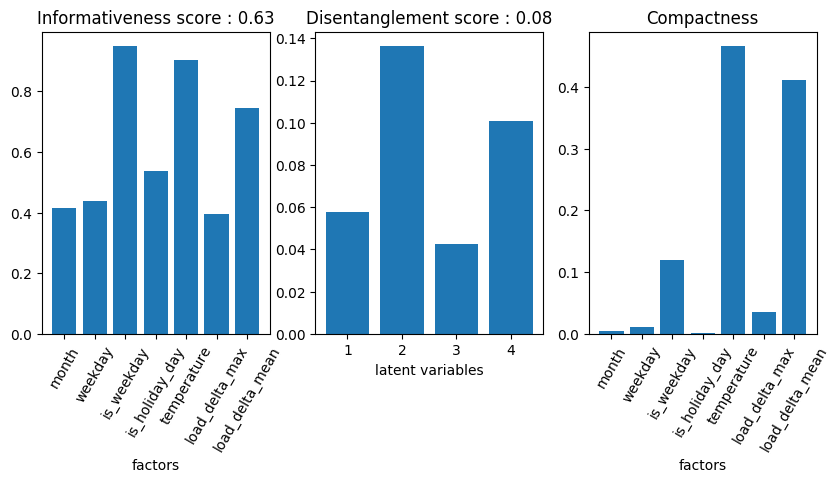

In [486]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

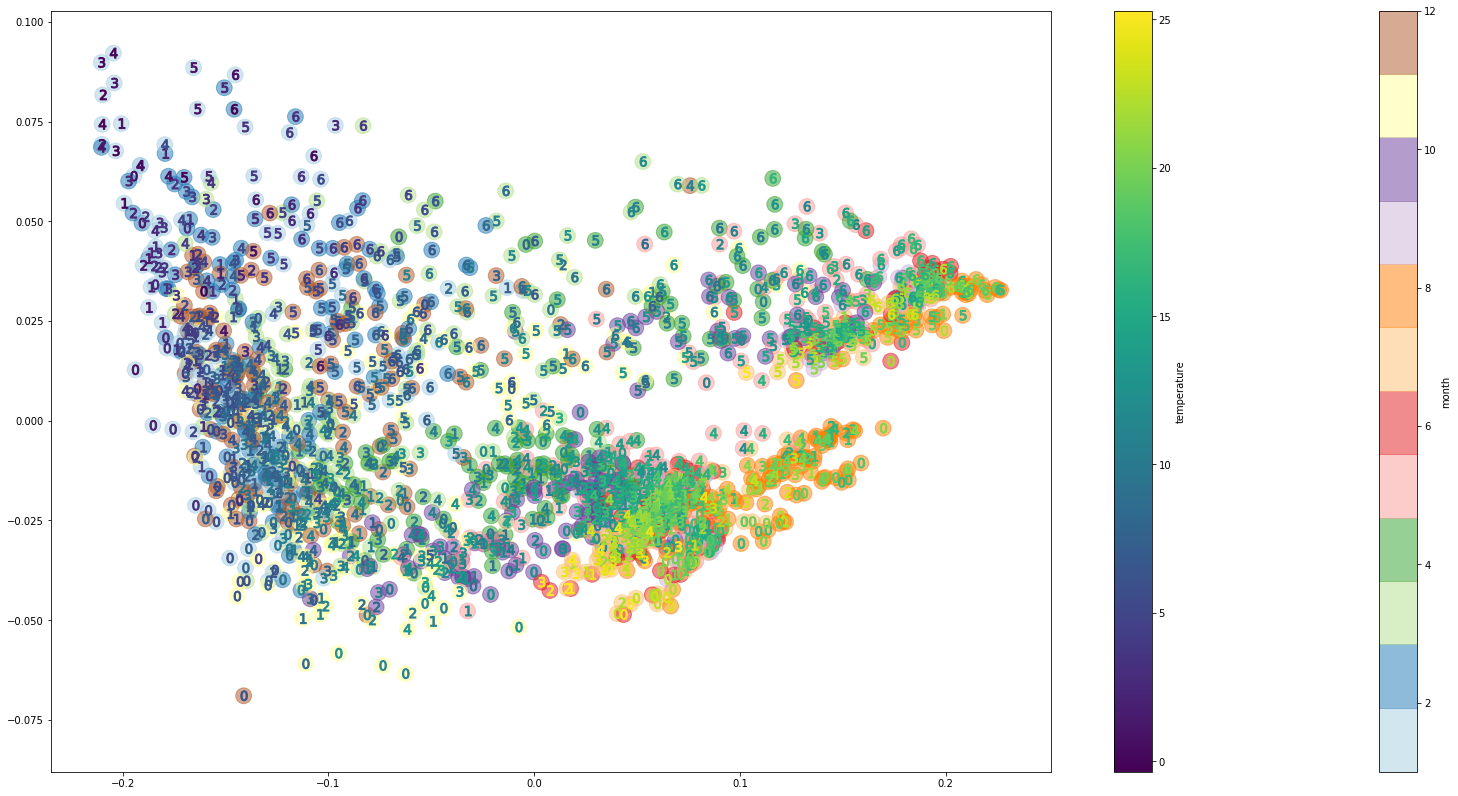

In [487]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(28,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=250, alpha=0.5, cmap = 'Paired')

plt.colorbar().set_label('month');

for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100)

plt.colorbar().set_label('temperature');

In [ ]:
x_hat = model_CVAE_cluster7.cvae.predict(input_encoder)[0]
tensorboardProjection(name_model, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True)

## CVAE conditioning on weekends and weekdays

In [91]:
name_model = 'cvae_conso-W_D_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=8,
                                beta=Beta, is_L2_Loss=False,
                                name=name_model, output=path_out)

L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 6287        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)         

In [92]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

[1214.2018  599.3368 1808.6073 2990.715 ]
5.287945968749999
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.995312  0.927064  0.335099        0.138182     0.796860
random model    0.475720  0.141598  0.092934        0.025455    -0.439158
0 Epochs ...  - loss: 37.6565 - decoder_loss: 36.5924 - decoder_for_kl_loss: 1.0641 - decoder_kl_loss: 1.0641 - decoder_recon_loss: 36.5924 - decoder_for_kl_kl_loss: 1.0641 - decoder_for_kl_recon_loss: 36.5924 - val_loss: 26.2071 - val_decoder_loss: 21.9092 - val_decoder_for_kl_loss: 4.2980 - val_decoder_kl_loss: 4.2980 - val_decoder_recon_loss: 21.9092 - val_decoder_for_kl_kl_loss: 4.2980 - val_decoder_for_kl_recon_loss: 21.9092 val_loss 26.207129462820586 ... lambda Loss 1.0
[  74.64184    46.092934   79.89682  1611.4181  ]
5.3493792395833335
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.968455  0.726895  0.343233        0.229091     0.

[  11.380479   18.656914  793.2267   1544.7189  ]
4.19069577604167
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.569532  0.198471  0.369888        0.298182     0.854958
random model    0.482777  0.153054  0.086876        0.018182    -0.385765
1100 Epochs ...  - loss: 6.7484 - decoder_loss: 3.7941 - decoder_for_kl_loss: 2.9543 - decoder_kl_loss: 2.9543 - decoder_recon_loss: 3.7941 - decoder_for_kl_kl_loss: 2.9543 - decoder_for_kl_recon_loss: 3.7941 - val_loss: 6.5913 - val_decoder_loss: 3.8122 - val_decoder_for_kl_loss: 2.7791 - val_decoder_kl_loss: 2.7791 - val_decoder_recon_loss: 3.8122 - val_decoder_for_kl_kl_loss: 2.7791 - val_decoder_for_kl_recon_loss: 3.8122 val_loss 6.591300151387199 ... lambda Loss 1.0
[  17.275383    8.736398  805.07404  1545.1589  ]
4.158115885416665
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.599735  0.195786  0.377224        0.283636     0.850907
random model    0.4

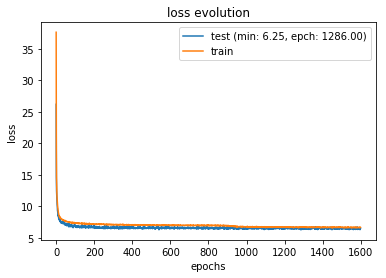

In [93]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset_cond['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE_cond.main_train(dataset_cond, training_epochs=2*epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE_cond.main_train(dataset_cond, training_epochs=2*epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)


In [94]:
x_input = dataset_cond['train']['x']

input_encoder = x_input

x_encoded = model_CVAE_cond.encoder.predict(input_encoder)[0]

Mutual Information Gap : 0.12


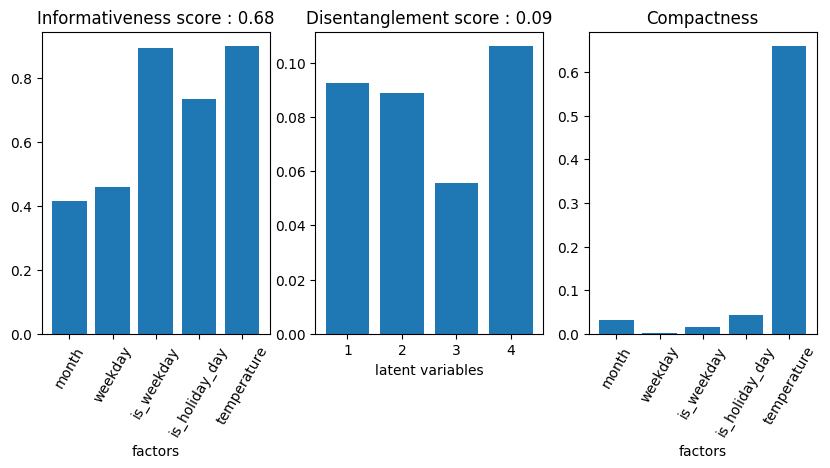

In [95]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

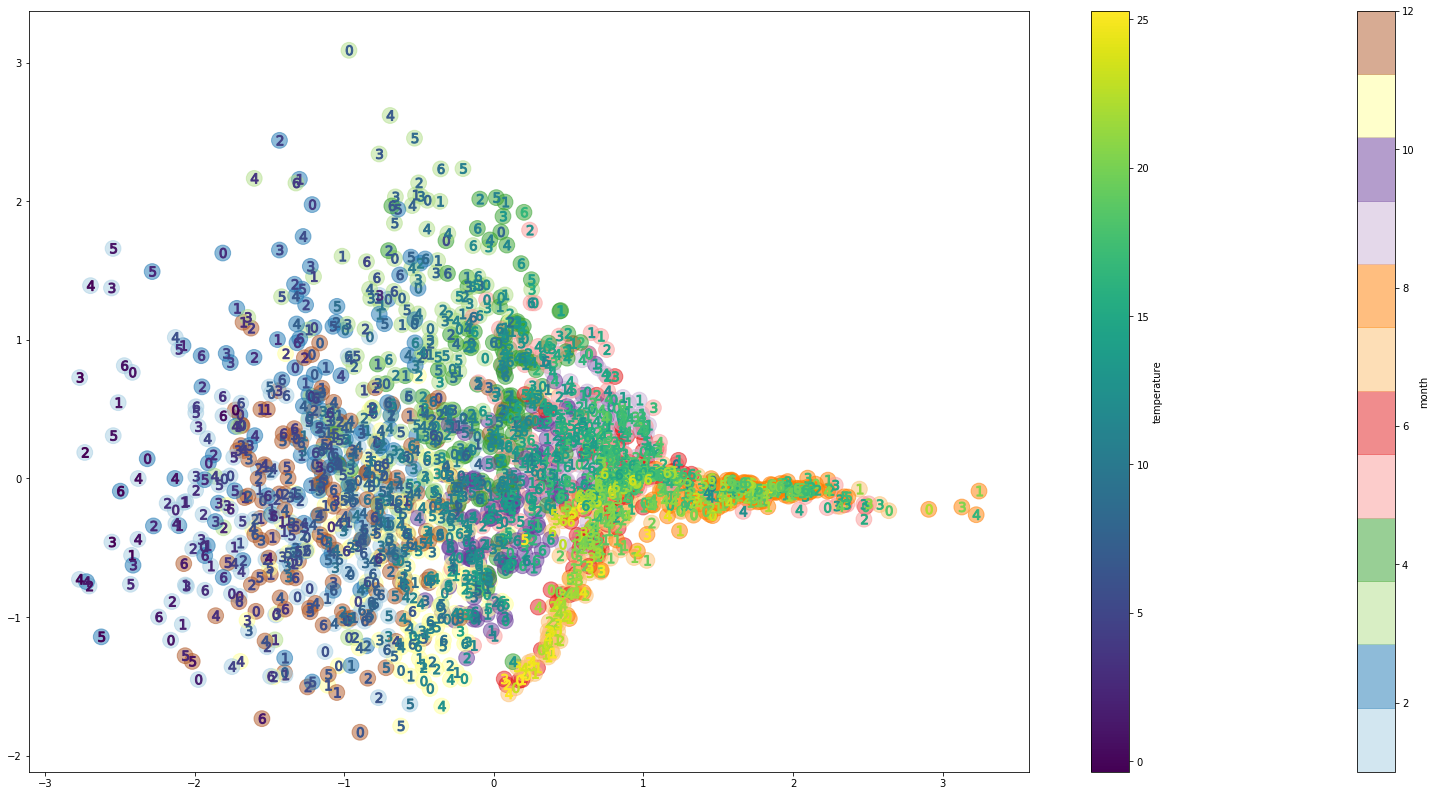

In [96]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(28,14))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=250, alpha=0.5, cmap = 'Paired')

plt.colorbar().set_label('month');

for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100)

plt.colorbar().set_label('temperature');

In [97]:
x_hat = model_CVAE_cond.cvae.predict(x=dataset_cond['train']['x'])[0]
tensorboardProjection(name_model, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True)

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/ModelComparison/VAE/projector/cvae_conso-W_D_30min-journalier


<Figure size 432x288 with 0 Axes>

## Mixture with conditions

In [488]:
name_model = 'cvae_mixture_cond_conso_30min-journalier'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
weights_mixture = [1,1,1,1]
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_mixture = CVAE.cvae_model_mixture.CVAE_cluster(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=8,
                                beta=Beta, is_L2_Loss=False,
                                proba_mixture=np.asarray(weights_mixture)/sum(weights_mixture),         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 13154       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
decoder (Model)                 [(None, 48), (None,  13255       encoder[1][2]

In [489]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [490]:
#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset_cond['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model_CVAE_cond_mixture.main_train(dataset_cond, training_epochs=2*epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model_CVAE_cond_mixture.main_train(dataset_cond, training_epochs=2*epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)




--- START TRAINING ---

[392.4613  772.4425  290.30075 842.79486]
4.423308052083332
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.992739  0.974397  0.423802        0.229091     0.843785
random model    0.484687  0.131704  0.084129        0.025455    -0.440185
0 Epochs ...  - loss: 47.7497 - decoder_loss: 39.9501 - decoder_for_kl_loss: 1.4033 - val_loss: 45.2062 - val_decoder_loss: 38.0717 - val_decoder_for_kl_loss: 0.8722 val_loss 45.2061900154489 ... lambda Loss 1.0


KeyboardInterrupt: 

In [102]:
x_input = dataset_cond['train']['x']

input_encoder = x_input

x_encoded,_,_, z_y = model_CVAE_cond_mixture.encoder.predict(input_encoder)
z_y = np.argmax(z_y, axis= 1)
stats.describe(z_y)

DescribeResult(nobs=1830, minmax=(0, 2), mean=1.8289617486338798, variance=0.3124467071199587, skewness=-2.9642515326782877, kurtosis=6.792381008539232)

Mutual Information Gap : 0.08


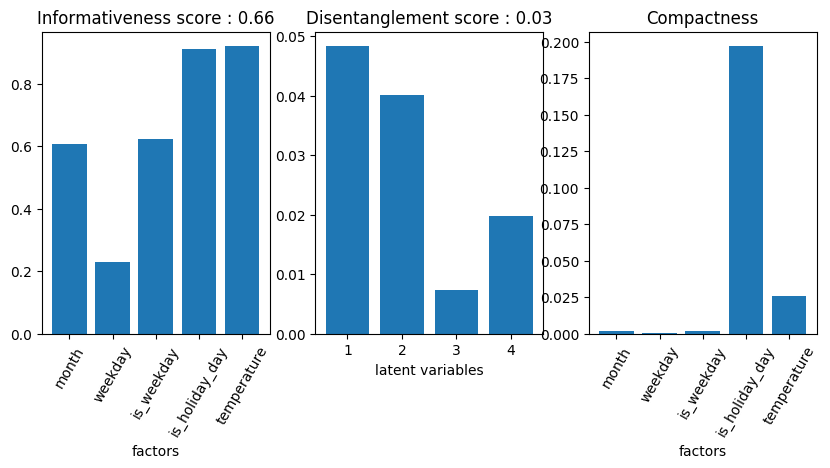

In [103]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('Mutual Information Gap : %.2f'%model_eval['mig'])

fig = plt.figure(dpi=100,figsize=(10,4))

plt.subplot(1, 3, 1)
fig.subplots_adjust(hspace=.5)
plt.bar(factorDesc.keys(),model_eval['informativeness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']));

plt.subplot(1, 3, 2)
plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
plt.xlabel('latent variables')
plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

plt.subplot(1, 3, 3)
plt.bar(factorDesc.keys(),model_eval['compactness'])
plt.xlabel('factors')
plt.xticks(rotation=60)
plt.title('Compactness');

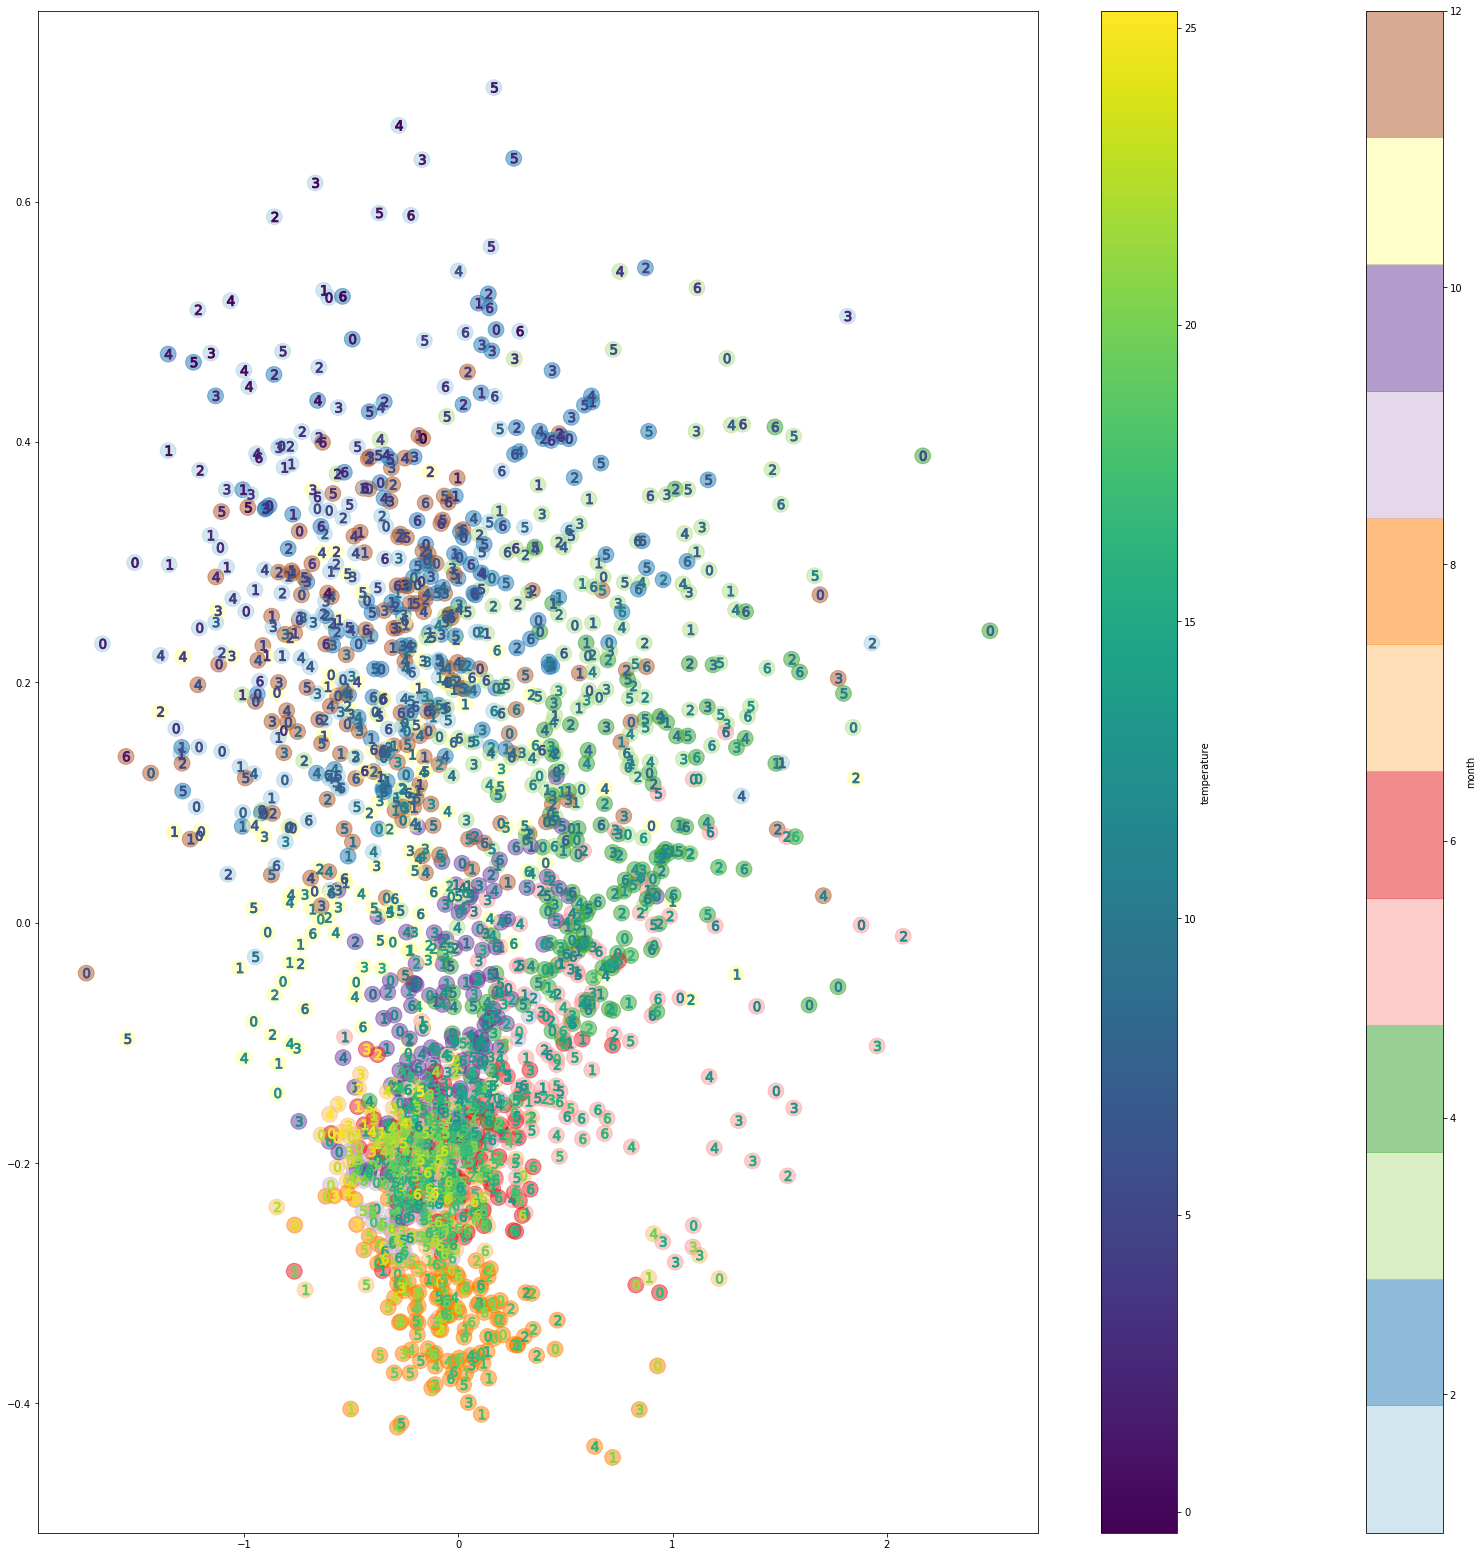

In [104]:
proj2D = PCA(2)
proj = proj2D.fit_transform(x_encoded)
plt.figure(figsize=(28,28))
for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=250, alpha=0.5, cmap = 'Paired')

plt.colorbar().set_label('month');

for i in np.unique(factorMatrix[:,1]):
    i = int(i)
    index = factorMatrix[:,1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=100)

plt.colorbar().set_label('temperature');

In [129]:
#sauvegarde du modèle
if runTraining:
    with open(os.path.join(log_dir_model,name_model,"config.txt"),'w') as file: 
        file.write(str(cond_pre_dim) + '\n')
        #file.write(str(emb_dims) + '\n')
        file.write(str(e_dims) + '\n') 
        file.write(str(d_dims) + '\n') 
        file.write(str(z_dim) + '\n')
        file.write(str(Beta) + '\n')
        
    name_dataset = 'dataset.pickle'

    with open( os.path.join(log_dir_model,name_model, name_dataset), "wb" ) as file:
        pickle.dump( dataset, file )



In [90]:
x_hat = model_CVAE_cond_mixture.cvae.predict(x=dataset_cond['train']['x'])[0]
tensorboardProjection(name_model, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True)

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/ModelComparison/VAE/projector/cvae_mixture_cond_conso_30min-journalier


<Figure size 432x288 with 0 Axes>

# Analysis of the latent space with the construction of a tensorboard projector

/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/ModelComparison/VAE/projector/cvae_mixture_cond_conso_30min-journalier


<Figure size 432x288 with 0 Axes>

# Predict Features in latent space

In [132]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

3.6384006145833334
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.852077  0.470669  0.584359        0.800000     0.893059
random model    0.464596  0.134370  0.088982        0.014545    -0.413346


# reconstruction error analysis

In [133]:
error=np.sum(np.abs((x - x_hat)),axis=1)/48

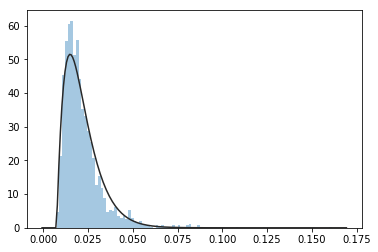

In [135]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.beta, bins=100)

Check the day with errors above a threshold

In [94]:
ErrorThreshold=0.08
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

ds  month  weekday  is_weekday  is_holiday_day     error
63  2013-03-01      3        4           1             0.0  0.085832
93  2013-03-31      3        6           0             0.0  0.094334
97  2013-04-04      4        3           1             0.0  0.083742
99  2013-04-06      4        5           0             0.0  0.081694
224 2013-08-09      8        4           1             0.0  0.097326
368 2013-12-31     12        1           1             0.0  0.088459
726 2014-12-24     12        2           1             0.0  0.120446

Check the first n days with highest errors 

In [95]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

ds  month  weekday  is_weekday  is_holiday_day     error
1769 2017-11-01     11        2           1             1.0  0.165082
1808 2017-12-10     12        6           0             0.0  0.122082
1828 2017-12-30     12        5           0             0.0  0.121746
726  2014-12-24     12        2           1             0.0  0.120446
1827 2017-12-29     12        4           1             0.0  0.119597
1790 2017-11-22     11        2           1             0.0  0.101839
1750 2017-10-13     10        4           1             0.0  0.098926
224  2013-08-09      8        4           1             0.0  0.097326
93   2013-03-31      3        6           0             0.0  0.094334
1823 2017-12-25     12        0           1             1.0  0.091963
1772 2017-11-04     11        5           0             0.0  0.090571
368  2013-12-31     12        1           1             0.0  0.088459
1822 2017-12-24     12        6           0             0.0  0.087516
63   2013-03-01      3        4           1             0.0  0.085832
97   2013-04-04      4        3           1             0.0  0.083742
99   2013-04-06      4        5           0             0.0  0.081694
1794 2017-11-26     11        6           0             0.0  0.080368
1759 2017-10-22     10        6           0             0.0  0.079751
1765 2017-10-28     10        5           0             0.0  0.078882
1078 2015-12-11     12        4           1             0.0  0.077522
1457 2016-12-24     12        5           0             0.0  0.077405
1406 2016-11-03     11        3           1             0.0  0.076814
1321 2016-08-10      8        2           1             0.0  0.076451
790  2015-02-26      2        3           1             0.0  0.076426
1829 2017-12-31     12        6           0             0.0  0.076016
449  2014-03-22      3        5           0             0.0  0.075997
1147 2016-02-18      2        3           1             0.0  0.074911
334  2013-11-27     11        2           1             0.0  0.074808
1820 2017-12-22     12        4           1             0.0  0.074559
1071 2015-12-04     12        4           1             0.0  0.074409

Visualize the reconstruction error over a specific day

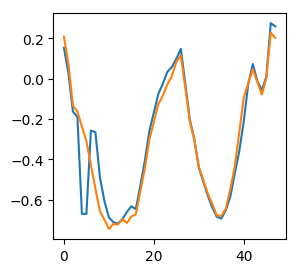

In [96]:
indice=1185 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

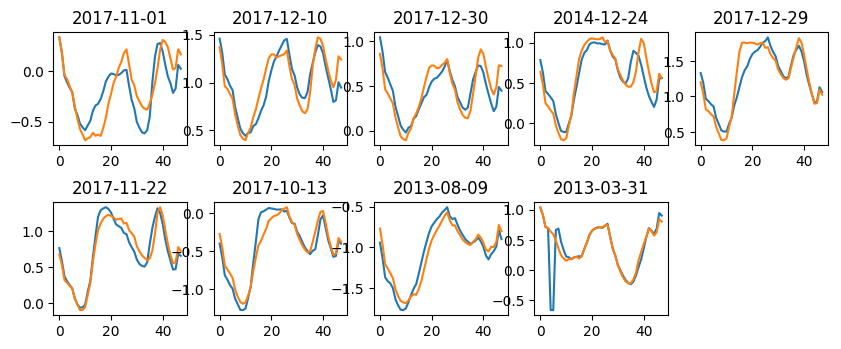

In [97]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [98]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [99]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)

## holidays well predicted

In [100]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

ds  month  weekday  is_weekday  is_holiday_day
4    2013-01-01      1        1           1             1.0
131  2013-05-08      5        2           1             1.0
369  2014-01-01      1        2           1             1.0
479  2014-04-21      4        0           1             1.0
528  2014-06-09      6        0           1             1.0
854  2015-05-01      5        4           1             1.0
1092 2015-12-25     12        4           1             1.0
1235 2016-05-16      5        0           1             1.0
1326 2016-08-15      8        0           1             1.0

In [101]:
yWeekday=calendar_info['is_weekday']
results_wk=scoreKnnResults(x_encoded,yWeekday,type='classifier',k=10,cv=10)

In [102]:
weekdays_predicted_as_weekend=[i for i in range(0,1830) if  results_wk['predP'][i]<=0.5 and yWeekday[i]==1]
calendar_info.loc[weekdays_predicted_as_weekend]

ds  month  weekday  is_weekday  is_holiday_day
3    2012-12-31     12        0           1             0.0
4    2013-01-01      1        1           1             1.0
94   2013-04-01      4        0           1             1.0
124  2013-05-01      5        2           1             1.0
131  2013-05-08      5        2           1             1.0
132  2013-05-09      5        3           1             1.0
143  2013-05-20      5        0           1             1.0
230  2013-08-15      8        3           1             1.0
308  2013-11-01     11        4           1             1.0
318  2013-11-11     11        0           1             1.0
362  2013-12-25     12        2           1             1.0
364  2013-12-27     12        4           1             0.0
368  2013-12-31     12        1           1             0.0
369  2014-01-01      1        2           1             1.0
479  2014-04-21      4        0           1             1.0
489  2014-05-01      5        3           1             1.0
496  2014-05-08      5        3           1             1.0
517  2014-05-29      5        3           1             1.0
563  2014-07-14      7        0           1             1.0
595  2014-08-15      8        4           1             1.0
683  2014-11-11     11        1           1             1.0
727  2014-12-25     12        3           1             1.0
731  2014-12-29     12        0           1             0.0
732  2014-12-30     12        1           1             0.0
733  2014-12-31     12        2           1             0.0
734  2015-01-01      1        3           1             1.0
735  2015-01-02      1        4           1             0.0
829  2015-04-06      4        0           1             1.0
854  2015-05-01      5        4           1             1.0
861  2015-05-08      5        4           1             1.0
867  2015-05-14      5        3           1             1.0
878  2015-05-25      5        0           1             1.0
928  2015-07-14      7        1           1             1.0
1048 2015-11-11     11        2           1             1.0
1091 2015-12-24     12        3           1             0.0
1092 2015-12-25     12        4           1             1.0
1096 2015-12-29     12        1           1             0.0
1098 2015-12-31     12        3           1             0.0
1099 2016-01-01      1        4           1             1.0
1186 2016-03-28      3        0           1             1.0
1224 2016-05-05      5        3           1             1.0
1235 2016-05-16      5        0           1             1.0
1294 2016-07-14      7        3           1             1.0
1326 2016-08-15      8        0           1             1.0
1404 2016-11-01     11        1           1             1.0
1414 2016-11-11     11        4           1             1.0
1461 2016-12-28     12        2           1             0.0
1463 2016-12-30     12        4           1             0.0
1571 2017-04-17      4        0           1             1.0
1585 2017-05-01      5        0           1             1.0
1592 2017-05-08      5        0           1             1.0
1609 2017-05-25      5        3           1             1.0
1620 2017-06-05      6        0           1             1.0
1659 2017-07-14      7        4           1             1.0
1691 2017-08-15      8        1           1             1.0
1769 2017-11-01     11        2           1             1.0
1823 2017-12-25     12        0           1             1.0

In [103]:
len(weekdays_predicted_as_weekend)

57

We find out that holidays actually look alike weekends even if they are happening during weekdays

# Holidays & nearest neighbors

<function matplotlib.pyplot.show(*args, **kw)>

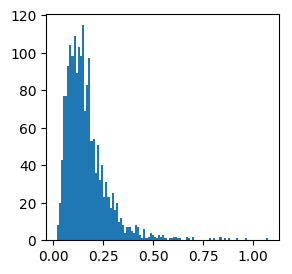

In [104]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [105]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.016541171424242395, 1.074540498547887), mean=0.16673077278509163, variance=0.012510367346743085, skewness=2.5012268081450864, kurtosis=10.545053959091563)

<function matplotlib.pyplot.show(*args, **kw)>

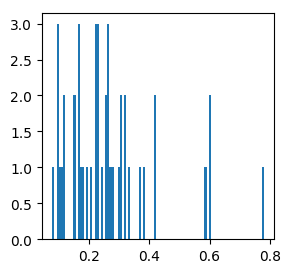

In [106]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [107]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=45, minmax=(0.07724092920572362, 0.7800549293110298), mean=0.2631268081068916, variance=0.022468491085609967, skewness=1.4799056215452613, kurtosis=2.342934273043145)

In [108]:
nearestThreshold=0.7
calendar_info.loc[np.where(nearest>=nearestThreshold)]

ds  month  weekday  is_weekday  is_holiday_day
21   2013-01-18      1        4           1             0.0
361  2013-12-24     12        1           1             0.0
703  2014-12-01     12        0           1             0.0
719  2014-12-17     12        2           1             0.0
730  2014-12-28     12        6           0             0.0
1092 2015-12-25     12        4           1             1.0
1120 2016-01-22      1        4           1             0.0
1466 2017-01-02      1        0           1             0.0
1491 2017-01-27      1        4           1             0.0
1583 2017-04-29      4        5           0             0.0

2013-01-18  and 2017-01-27 were big snowy events in France and first of january are alwaus atypical days. All of those events happened durng winter, when the electrical consumption is most sensitive to temperature.

In [110]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=nearestThreshold]
nearest[np.where(nearest>=nearestThreshold)]

array([0.95991154, 0.80261123, 1.0745405 , 0.85577207, 0.91793625,
       0.78005493, 0.84032683, 0.70019336, 0.84032683, 0.87500159])

<bound method Figure.show of <Figure size 1000x600 with 10 Axes>>

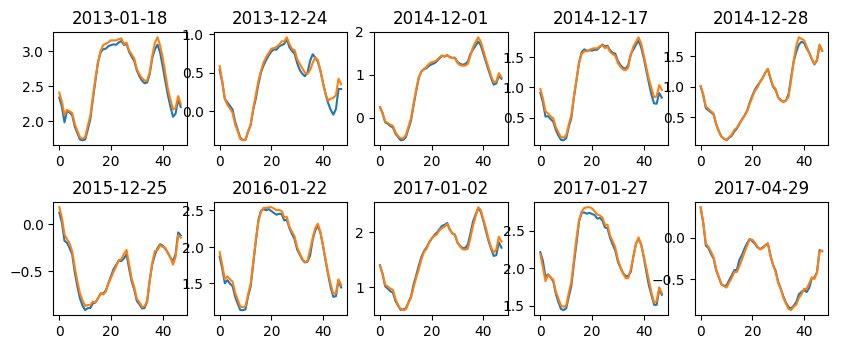

In [111]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- 3 dimensions covers most of the information for the variety of daily load curves 
- We recovered with this simple linear model the two main features that caracterizes electrical consumption: weekday and temperature
- Holidays are not yet well predicted and represented, although we know they are an important atypical factor.
- We however detect that holidays all look alike weekend days
- We discover some first interpretable events.
- Results are quite similar than with the PCA model. They are some differences in the events first detected. The projection in the latent space is also more gaussian, which ease the interactive navigation in it, compared to the PCA projection.

